We would need latest sklearn version to use 'get_feature_names_out' of Columntransformer.So upgrading scikit-learn first

In [0]:
import sklearn

sklearn.__version__

Out[1]: '0.24.2'

In [0]:
pip install -U scikit-learn

Python interpreter will be restarted.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Not uninstalling scikit-learn at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-36ed58e5-0d76-4d8e-9957-09b5354d8b15
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mleap 0.20.0 requires scikit-learn<0.23.0,>=0.22.0, but you have scikit-learn 1.1.3 which is incompatible.
Python interpreter will be restarted.


In [0]:
import sklearn

sklearn.__version__

Out[1]: '1.1.3'

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
import mlflow.xgboost
import xgboost as xgb
from mlflow.models.signature import infer_signature

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

Loading the already splitted train and test dataframes from demo-02.
Checking the number of rows and columns

In [0]:
X_train = pd.read_csv('/dbfs/FileStore/datasets/processed_x_train.csv')
X_test = pd.read_csv('/dbfs/FileStore/datasets/processed_x_test.csv')
y_train = pd.read_csv('/dbfs/FileStore/datasets/processed_y_train.csv')
y_test = pd.read_csv('/dbfs/FileStore/datasets/processed_y_test.csv')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Out[3]: ((34062, 10), (14598, 10), (34062, 1), (14598, 1))

In [0]:
X_train.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
0,Procurement,Bachelor's,f,other,1,35,2.0,6,0,71
1,Operations,Bachelor's,m,sourcing,3,35,3.0,12,0,76
2,Procurement,Bachelor's,m,sourcing,1,36,4.0,7,0,66
3,Finance,Master's & above,m,other,1,41,2.0,9,0,59
4,Sales & Marketing,Bachelor's,m,other,2,33,3.0,4,0,48


Categorical features are listed and One hot encoder is defined

In [0]:
categorical_features = ['department', 'recruitment_channel', 'education', 'gender']

categorical_transformer = OneHotEncoder(drop = 'first')

ColumnTransformer : This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. Here We are using Column Transformer to one hot encode categorical features defined above and Standard scale remaining numerical features

In [0]:
preprocessor = ColumnTransformer(
    transformers = [('cat', categorical_transformer, categorical_features)], 
    remainder = StandardScaler() 
)

print(preprocessor)

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['department', 'recruitment_channel',
                                  'education', 'gender'])])


We are defining the model

In [0]:
rf_model = RandomForestClassifier()

Pipeline is defined with preprocessing and model building steps

In [0]:
pipeline = Pipeline(
    steps = [('preprocessor', preprocessor), ('classifier',  rf_model)]
)

This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.We are logging the metrics using log_metric method.Also infer signature is defined which is required to validate the inputs. Model is also logged here. Metrics observed after  run is auc: 0.765
test_accuracy: 0.933
test_f1_score: 0.468
test_precision_score: 0.757
test_recall_score: 0.339

Note that we are not autologging parameters here.Note that signatures of training data can also be seen by clicking MLModel under rfmodel under  Model artifacts as we are using infer_signature.

- log_models=False is configured in autolog. This prevents MLflow to automatically log the model, as it is done manually later.
- infer_signature is a convenient method to try to infer the signature directly from inputs and outpus.

2022/11/08 06:57:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2022/11/08 06:57:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/11/08 06:57:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/11/08 06:57:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/11/08 06:57:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare intege

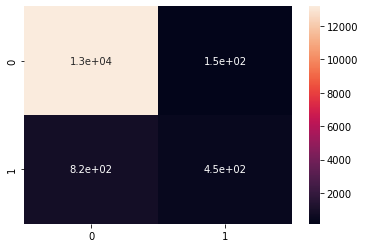

In [0]:
mlflow.autolog(log_models=False)

with mlflow.start_run() as run1:
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    pipeline.fit(X_train, y_train)
    
    predictions =  pipeline.predict(X_test)
    predictions_proba = pipeline.predict_proba(X_test)
    
    test_accuracy = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_proba[:, 1])
    
    mlflow.log_metric('test_accuracy',  test_accuracy)
    mlflow.log_metric('test_precision', test_precision_score)
    mlflow.log_metric('test_recall', test_recall_score)
    mlflow.log_metric('test_f1', test_f1_score)
    mlflow.log_metric('auc_score', auc_score)
    
    cf_matrix = confusion_matrix(y_test, predictions)
    
    sns.heatmap(cf_matrix, annot=True)
    plt.savefig("confusion_matrix_test.png")
    mlflow.log_artifact("confusion_matrix_test.png") 
    
    signature = infer_signature(X_train, pipeline.predict(X_train))
    mlflow.sklearn.log_model(sk_model = pipeline, artifact_path = 'rf_model', signature = signature)

We would be using XGBOOST to train our data.So data is preprocessed in order to feed into the model.Preprocessed sample can be viewed. Note that scikit learn api is not supported for mlflow autologging.So scikit learn pipeline is not used here

In [0]:
X_train_processed = pd.DataFrame(preprocessor.fit_transform(X_train),
                                 columns =  preprocessor.get_feature_names_out(),
                                 index = X_train.index)

X_test_processed = pd.DataFrame(preprocessor.transform(X_test),
                                columns = preprocessor.get_feature_names_out(), 
                                index = X_test.index)
X_train_processed.sample(10)

,cat__department_Finance,cat__department_HR,cat__department_Legal,cat__department_Operations,cat__department_Procurement,cat__department_R&D,cat__department_Sales & Marketing,cat__department_Technology,cat__recruitment_channel_referred,cat__recruitment_channel_sourcing,cat__education_Below Secondary,cat__education_Master's & above,cat__gender_m,cat__gender_others,remainder__no_of_trainings,remainder__age,remainder__previous_year_rating,remainder__length_of_service,remainder__awards_won?,remainder__avg_training_score
29550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.416935,0.448490,1.321198,0.157806,-0.156174,-0.878120
26015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.416935,-0.082284,1.321198,-0.792165,-0.156174,1.756631
18097,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.416935,0.183103,1.321198,0.395298,-0.156174,0.476895
8244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.416935,-0.347671,-0.268356,-1.029658,-0.156174,1.380238
5048,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.416935,-1.011138,-1.063133,-1.029658,-0.156174,-1.028677
25072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.416935,-0.745751,0.526421,-1.029658,-0.156174,0.928567
7658,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.416935,0.183103,0.526421,-0.079687,-0.156174,0.778009
25444,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.230778,0.713877,-0.268356,-0.554673,-0.156174,0.326338
14298,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.416935,0.050410,-1.063133,0.395298,-0.156174,-1.254513
11629,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.416935,0.050410,-1.857909,0.870284,-0.156174,-1.103956


Parameters for training are defined.Note that first we will run the below cell by uncommenting. In this case XGBOOST model is increasing precision better than recall.As this dataset is highly imbalanced,We would use 'scale_pos_weight' to treat the imbalance. Negative/Positive ratio is around 11.After increasing 'scale_pos_weight' it can be seen that recall increased significantly but precision reduced significantly.
ref.link for 'scale_pos_weight' parameter-

https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster

Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)

In [0]:
param = {'max_depth': 3, 'eta': 0.1, 'min_child_weight': 3, 'objective': 'binary:logistic', 'eval_metric':'logloss'}
param['nthread'] = 4

In [0]:
# param = {'max_depth': 3, 'eta': 0.1, 'min_child_weight': 3, 'objective': 'binary:logistic', 'scale_pos_weight': 11, 'eval_metric':'logloss'}
# param['nthread'] = 4

With  autologging, hyperparameters and the trained model are automatically logged to MLflow.Note that predictions from booster model is probabilities.So we are round it to get the prediction label.But in case of computation of roc_auc score value we need the probabilities.
 Metrics oberved after training are 
 auc: 0.811
test_accuracy: 0.942
test_f1_score: 0.511
test_precision_score: 0.933
test_recall_score: 0.352
test-logloss: 0.202
So using XGBOOST , AUC,F1 score,precision have improved.We can use other Data preprocessing steps like oversampling and hyperparameter tuning further to improve the model

In [0]:
mlflow.xgboost.autolog()

with mlflow.start_run():
    train = xgb.DMatrix(data = X_train_processed, label = y_train)
    test = xgb.DMatrix(data = X_test_processed, label = y_test)
    
    booster = xgb.train(params = param, dtrain = train, num_boost_round = 1000,\
                        evals = [(test, 'test')], early_stopping_rounds = 50)
    
    predictions_test = booster.predict(test)
    y_pred = [round(value) for value in predictions_test]
    
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision_score = precision_score(y_test, y_pred)
    test_recall_score = recall_score(y_test, y_pred)
    test_f1_score = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, predictions_test)
        
    mlflow.log_metric('test_accuracy',  test_accuracy)
    mlflow.log_metric('test_precision', test_precision_score)
    mlflow.log_metric('test_recall', test_recall_score)
    mlflow.log_metric('test_f1', test_f1_score)
    mlflow.log_metric('AUC_score', auc_score)
 

[0]	test-logloss:0.61555
[1]	test-logloss:0.55322
[2]	test-logloss:0.50244
[3]	test-logloss:0.46059
[4]	test-logloss:0.42581
[5]	test-logloss:0.39692
[6]	test-logloss:0.37267
[7]	test-logloss:0.35241
[8]	test-logloss:0.33551
[9]	test-logloss:0.32145
[10]	test-logloss:0.30983
[11]	test-logloss:0.30030
[12]	test-logloss:0.29252
[13]	test-logloss:0.28634
[14]	test-logloss:0.28152
[15]	test-logloss:0.27790
[16]	test-logloss:0.27529
[17]	test-logloss:0.27356
[18]	test-logloss:0.27246
[19]	test-logloss:0.27203
[20]	test-logloss:0.27204
[21]	test-logloss:0.27253
[22]	test-logloss:0.27352
[23]	test-logloss:0.27490
[24]	test-logloss:0.27659
[25]	test-logloss:0.27871
[26]	test-logloss:0.28074
[27]	test-logloss:0.28300
[28]	test-logloss:0.28546
[29]	test-logloss:0.28796
[30]	test-logloss:0.29063
[31]	test-logloss:0.29329
[32]	test-logloss:0.29586
[33]	test-logloss:0.29856
[34]	test-logloss:0.30129
[35]	test-logloss:0.30387
[36]	test-logloss:0.30652
[37]	test-logloss:0.30912
[38]	test-logloss:0.31

#### TODO Recording

- After the first run, click on "1 run" to view the results of the run
- Open up Parameters and Metrics and show the accuracy, precision, recall (precision is high, recall is low)
- Go to Artifacts - Select MLModel, conda.yaml, requirements.txt
- click on Features Importances both JSON and image and show
- Go back and comment out the original parameters and unselect the parameters which has scale_pos_weight=11
- Re-run the code
- Open up the second run and show Metrics, show how recall has improved
- Show Feature Importances for this new run (they are a little different)